# Supervised Learning of Actions 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
exportdir='/data/localhost/taufiq/export-dir/'

In [3]:
import logging
logging.basicConfig(filename='logistic-regression.log', level=logging.INFO)

In [4]:
nra = 5
nr_reps = 50

In [5]:
MIMICtable = pd.read_csv(exportdir + '/MIMIC-1hourly-length-5.csv')
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,65537,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267
1,2,65537,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600
2,3,65537,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900
3,4,65537,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900
4,5,65537,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.0,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317


In [6]:
#################   Convert training data and compute conversion factors    ######################
logging.info('Processing raw data')
# all 47 columns of interest
colbin = ['gender','mechvent','re_admission']
colnorm=['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',\
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',\
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',\
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance']
collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','output_total','output_1hourly']

MIMICraw = MIMICtable[colbin+colnorm+collog].copy()

for col in MIMICraw:
    if col in colbin:
        MIMICraw[col] = MIMICraw[col] - 0.5
    elif col in colnorm:
        cmu = MIMICraw[col].mean()
        csigma = MIMICraw[col].std()
        MIMICraw[col] = (MIMICraw[col] - cmu)/csigma
    else:
        log_values = np.log(0.1 + MIMICraw[col])
        dmu = log_values.mean()
        dsigma = log_values.std()
        MIMICraw[col] = (log_values - dmu)/dsigma    
logging.info('Raw data processed')

## Include the information for doses taken until time $t$

In [7]:
logging.info('Adding input values to X')

MIMICraw['last_input'] = 0.0
MIMICraw['total_input_before'] = 0.0
MIMICraw['last_vaso_dose'] = 0.0

for index, row in MIMICtable.iterrows():
    if index < len(MIMICtable) - 1 and (MIMICtable.at[index+1,'icustay_id'] == MIMICtable.at[index,'icustay_id']):
        MIMICraw.at[index+1, 'last_input'] = MIMICtable.at[index, 'input_1hourly']
        MIMICraw.at[index+1, 'total_input_before'] = MIMICtable.at[index, 'input_total']
        MIMICraw.at[index+1, 'last_vaso_dose'] = MIMICtable.at[index, 'max_dose_vaso']

def log_normalise(colname):
    global MIMICraw
    log_values = np.log(0.1 + MIMICraw[colname])
    dmu = log_values.mean()
    dsigma = log_values.std()
    MIMICraw[colname] = (log_values - dmu)/dsigma

log_normalise('last_input')
log_normalise('total_input_before')
MIMICraw['last_vaso_dose'] = MIMICraw['last_vaso_dose'] - 0.5

logging.info('Input values added to X')

/homes/taufiq/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# MIMICraw.to_csv(exportdir + '/MIMICraw-logistic_reg-1hourly.csv', index = False)
# MIMICraw = pd.read_csv(exportdir + '/MIMICraw-logistic_reg-1hourly.csv')
MIMICraw.head()

,gender,mechvent,re_admission,age,Weight_kg,GCS,HR,SysBP,MeanBP,DiaBP,...,Creatinine,SGOT,SGPT,Total_bili,INR,output_total,output_1hourly,last_input,total_input_before,last_vaso_dose
0,-0.5,-0.5,0.5,-0.180877,1.028268,0.390051,-0.552718,-0.436127,0.135833,0.010776,...,-0.235148,4.723310,4.927069,2.460978,-0.706871,0.091642,0.314742,-0.844613,-1.272434,-0.50
1,-0.5,-0.5,0.5,-0.180877,0.684850,0.681512,-0.912790,-0.207482,0.001679,0.353227,...,-1.241375,-1.139896,-0.791096,-0.742843,0.565076,0.222008,0.306706,0.905418,0.808432,-0.32
2,-0.5,-0.5,0.5,-0.180877,0.684850,0.390051,-0.530560,-0.847687,-0.991054,-0.879596,...,-1.241375,-1.139896,-0.791096,-0.742843,-0.706871,0.313933,0.301590,1.776558,0.809891,-0.50
3,-0.5,-0.5,0.5,-0.180877,-0.324965,0.681512,-0.137250,-0.756230,-0.719394,-0.365920,...,-0.560111,0.332674,0.484975,-1.232941,0.565076,0.384190,0.293251,1.795289,0.833400,-0.50
4,-0.5,-0.5,0.5,-0.180877,0.206516,-0.192872,-0.095703,-0.710501,-0.249858,-0.194695,...,-0.560111,0.400516,-0.583682,-0.956932,0.565076,0.438264,0.266998,2.206859,0.855642,-0.50


## Create Actions


In [9]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable.loc[MIMICtable['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable)) # array of ones, by default
io[MIMICtable['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable['max_dose_vaso'].copy()
vc_nonzero = MIMICtable.loc[MIMICtable['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable.loc[io==1, 'input_1hourly'].median(), MIMICtable.loc[io==2, 'input_1hourly'].median(), MIMICtable.loc[io==3, 'input_1hourly'].median(), MIMICtable.loc[io==4, 'input_1hourly'].median(), MIMICtable.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [14]:
# actionbloc.to_csv("/data/localhost/taufiq/export-dir/MIMICtable-actionbloc-1hourly.csv")
# actionbloc = pd.read_csv("/data/localhost/taufiq/export-dir/MIMICtable-actionbloc-1hourly.csv")

In [23]:
# uniqueValueDoses.to_csv("/data/localhost/taufiq/export-dir/MIMICtable-uniquevaluedoses.csv")
# uniqueValueDoses = pd.read_csv("/data/localhost/taufiq/export-dir/MIMICtable-uniquevaluedoses.csv")

In [11]:
actionbloc.head()

,action_bloc
0,1
1,2
2,2
3,2
4,2


In [23]:
action_count = {}
for index, row in actionbloc.iterrows():
    if (index+1)% 5 == 0:
        if key in action_count:
            action_count[key] += 1
        else:
            action_count[key] = 1
        key = str(row['action_bloc'])
    elif index == 0:
        key = str(row['action_bloc'])
    else:
        key += str(row['action_bloc'])

In [36]:
y = list(action_count.values())
y.sort(reverse=True)

In [31]:
len(MIMICtable)/5

6177.0

<BarContainer object of 1845 artists>

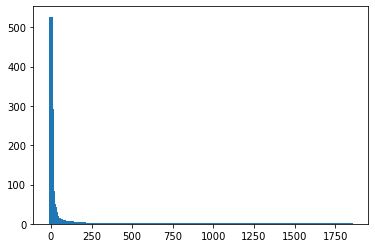

In [49]:
import matplotlib.pyplot as plt
plt.bar(range(len(y)), y, width=30)

In [11]:
MIMICtable = pd.read_csv(exportdir + '/MIMICtable-1hourly.csv')

In [47]:
icustayids = pd.Series(MIMICtable['icustay_id'].unique())
blocs = {7, 8, 9, 10, 11}
icustayids_subset = icustayids[icustayids.map(lambda x: blocs.issubset(set(MIMICtable.loc[MIMICtable['icustay_id']==x, 'bloc'])))]

In [49]:
MIMICtable_filtered = MIMICtable.loc[MIMICtable['icustay_id'].isin(icustayids_subset) & MIMICtable['bloc'].isin(blocs)]


In [55]:
mimic_with_actions = pd.read_csv(exportdir + '/MIMIC-1hourly-length-5-filtered.csv')

In [56]:
mimic_with_actions.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance,A
0,1,65537,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267,1
1,2,65537,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600,2
2,3,65537,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900,2
3,4,65537,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900,2
4,5,65537,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317,2


In [57]:
def action_bin(iv_dose, vp_dose):
    for a in range(1, 26):
        iv_doses = mimic_with_actions.loc[mimic_with_actions['A']==a, 'input_1hourly']
        vp_doses = mimic_with_actions.loc[mimic_with_actions['A']==a, 'median_dose_vaso']
        if (iv_dose >= iv_doses.min()) and (iv_dose <= iv_doses.max()) and (vp_dose >= vp_doses.min()) and (vp_dose <= vp_doses.max()):
            return a
    return a        

In [88]:
MIMICtable_filtered['A'] = MIMICtable_filtered.copy().apply(lambda x: action_bin(x['input_1hourly'], x['median_dose_vaso']), axis=1)

<ipython-input-88-f242e811071e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MIMICtable_filtered['A'] = MIMICtable_filtered.copy().apply(lambda x: action_bin(x['input_1hourly'], x['median_dose_vaso']), axis=1)


In [90]:
MIMICtable_filtered_no_dup = MIMICtable_filtered.loc[~MIMICtable_filtered['icustay_id'].isin(mimic_with_actions['icustay_id'])]
MIMICtable_filtered_no_dup.loc[:,'bloc'] = MIMICtable_filtered_no_dup['bloc'] - 6

In [91]:
MIMIC_combined = pd.concat([mimic_with_actions, MIMICtable_filtered_no_dup])

In [95]:
MIMIC_combined.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance,A
0,1.0,65537.0,7.139723e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.687500,363.888889,0.18,0.18,4020.493550,29.994183,7235.0,3605.0,-3184.512267,1
1,2.0,65537.0,7.139727e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.602564,430.555556,0.00,0.00,4050.487733,515.407667,10760.0,3525.0,-6194.104600,2
2,3.0,65537.0,7.139731e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.751456,402.222222,0.00,0.00,4565.895400,547.876700,14235.0,3475.0,-9121.227900,2
3,4.0,65537.0,7.139734e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.804762,275.000000,0.00,0.00,5113.772100,2097.144000,17630.0,3395.0,-10419.083900,2
4,5.0,65537.0,7.139738e+09,0.0,22799.40478,4.0,1.0,0.0,0.0,0.0,...,0.804245,283.000000,0.00,0.00,7210.916100,519.833583,20785.0,3155.0,-13054.250317,2


In [96]:
MIMIC_combined.to_csv("/data/localhost/taufiq/export-dir/MIMIC-1hourly-length-5-combined.csv", index=False)